In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import os
from collections import Counter
import matplotlib.pyplot as plt
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32
max_vocab_size = 20000

In [2]:
# batch_size = 8
# batch_size = 16
epochs = 20
no_cuda = False
log_interval = 1

cuda = not no_cuda and torch.cuda.is_available()
# cuda = False

seed = 1
torch.manual_seed(seed)

# device = torch.device("cuda" if args.cuda else "cpu")
device = torch.device("cuda" if cuda else "cpu")

# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [3]:
m_train = pd.read_table('hw2_data/mnli_train.tsv') 
m_val = pd.read_table('hw2_data/mnli_val.tsv') 
s_train = pd.read_table('hw2_data/snli_train.tsv') 
s_val = pd.read_table('hw2_data/snli_val.tsv')

print(m_train.shape)
print(m_val.shape)
print(s_train.shape)
print(s_val.shape)

(20000, 4)
(5000, 4)
(100000, 3)
(1000, 3)


In [4]:
targetlist = list(s_train['label'].unique())
target2id = dict(zip(targetlist, range(len(targetlist))))
#print(target2id)

In [5]:
def target_convert(labels):      
    return [target2id[i] for i in labels]  

In [6]:
m_train['target'] = target_convert(m_train['label'])
m_val['target'] = target_convert(m_val['label'])
s_train['target'] = target_convert(s_train['label'])
s_val['target'] = target_convert(s_val['label'])

In [7]:
s_val

,sentence1,sentence2,label,target
0,"Three women on a stage , one wearing red shoes...",There are two women standing on the stage,contradiction,2
1,"Four people sit on a subway two read books , o...","Multiple people are on a subway together , wit...",entailment,1
2,bicycles stationed while a group of people soc...,People get together near a stand of bicycles .,entailment,1
3,Man in overalls with two horses .,a man in overalls with two horses,entailment,1
4,Man observes a wavelength given off by an elec...,The man is examining what wavelength is given ...,entailment,1
5,Two people are in a green forest .,The forest is not dead .,entailment,1
6,Two men are listening to music through headpho...,Two men listen to music .,entailment,1
7,"Two women , one walking her dog the other push...",There is a snowstorm .,contradiction,2
8,A group of numbered participants walk down the...,Participants wait for the beginning of the wal...,neutral,0
9,Three people and a white dog are sitting in th...,Three dogs and a person are sitting in the snow .,contradiction,2


In [8]:
# tokenize sentence
def tokenize_sen(sen):
    lines = sen.split(' ')
    symbols = '!?${}()[],.:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("","",symbols)).strip().lower(), lines)
    return list(filter(None, words))
print(tokenize_sen('A toddler prepares to throw a Frisbee .'))

['a', 'toddler', 'prepares', 'to', 'throw', 'a', 'frisbee']


In [9]:
def tokenize_senlist(senlist):
    token_dataset = []
    all_tokens = []
    
    for sample in senlist:
        tokens = tokenize_sen(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [10]:
sentence1, all_tokens1 = tokenize_senlist(s_train['sentence1'])
sentence2, all_tokens2 = tokenize_senlist(s_train['sentence2'])
sentence1v, all_tokens1v = tokenize_senlist(s_val['sentence1'])
sentence2v, all_tokens2v = tokenize_senlist(s_val['sentence2'])
all_train_tokens = all_tokens1 + all_tokens2

In [11]:
# save index 0 for unk and 1 for pad
def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [12]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_sen1_indices = token2index_dataset(sentence1)
train_sen2_indices = token2index_dataset(sentence2)
val_sen1_indices = token2index_dataset(sentence1v)
val_sen2_indices = token2index_dataset(sentence2v)


# double checking
print ("Train sentence 1 size is {}".format(len(train_sen1_indices)))
print ("Train sentence 2 size is {}".format(len(train_sen2_indices)))
print ("Validation sentence 1 size is {}".format(len(val_sen1_indices)))
print ("Validation sentence 2 size is {}".format(len(val_sen2_indices)))

Train sentence 1 size is 100000
Train sentence 2 size is 100000
Validation sentence 1 size is 1000
Validation sentence 2 size is 1000


In [13]:
class Prep_Data(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, sen1, sen2, target_list):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.sen1 = sen1
        self.sen2 = sen2
        self.target_list = target_list
        assert (len(self.sen1) == len(self.target_list)) and (len(self.sen2) == len(self.target_list))


    def __len__(self):
        return len(self.sen1)

    def __getitem__(self, index):
        """
        Triggered when you call dataset[i]
        """
        char_idx1 = self.sen1[index][:MAX_WORD_LENGTH]
        char_idx2 = self.sen2[index][:MAX_WORD_LENGTH]
        label = self.target_list[index]
        return [char_idx1, char_idx2, len(char_idx1), len(char_idx2), label]

def data_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[2])
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_WORD_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        padded_vec2 = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_WORD_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        data_list2.append(padded_vec2)    
#     ind_dec_order = np.argsort(length_list)[::-1]
#     data_list = np.array(data_list)[ind_dec_order]
#     length_list = np.array(length_list)[ind_dec_order]
#     label_list = np.array(label_list)[ind_dec_order]
    return [torch.from_numpy(np.array(data_list1)), torch.from_numpy(np.array(data_list2)), torch.LongTensor(length_list1), torch.LongTensor(length_list2), torch.LongTensor(label_list)]

In [14]:
MAX_WORD_LENGTH = 90

In [15]:
# create pytorch dataloader
train_dataset = Prep_Data(train_sen1_indices, train_sen2_indices, list(s_train['target']))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = Prep_Data(val_sen1_indices, val_sen2_indices, list(s_val['target']))
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

#print(type(train_dataset[0][4]))
# for i, (data1, data2, lengths1, lengths2, labels) in enumerate(val_loader):
#     print (data1)
#     print (data2)
#     print (labels)
#     break

# data1, data2, length_batch1, length_batch2, label_batch = next(iter(val_loader))
# print(data1)

In [16]:
len_d1 = []
for i, (data1, data2, lengths1, lengths2, labels) in enumerate(val_loader):
    for i in range(32):
        len_d1.append(len(data1[0]))
    print(len_d1)
    print (len(data1))
    print (data2)
    print (labels)
    break

[90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
32
tensor([[220,  14,   9,  ...,   0,   0,   0],
        [ 49,   9,  13,  ...,   0,   0,   0],
        [  2,   6,   5,  ...,   0,   0,   0],
        ...,
        [  2,  25,   5,  ...,   0,   0,   0],
        [135,   5, 230,  ...,   0,   0,   0],
        [ 49,   9, 587,  ...,   0,   0,   0]])
tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 1, 0, 0, 2, 1, 2, 2, 2, 2,
        1, 0, 1, 2, 2, 0, 1, 1])


In [17]:
# Check max length of the sentence
lengths1_list = []
lengths2_list = []
for data1, data2, lengths1, lengths2, labels in train_loader:
    for i in range(32):
        lengths1_list.append(lengths1[i])
        lengths2_list.append(lengths2[i])
print(len(lengths1_list))
print(len(lengths2_list))
print(max(lengths1_list))
print(max(lengths2_list))

100000
100000
tensor(78)
tensor(38)


In [18]:
# wikiwords = 220,000 for basic model and drop out 0.2
wikiwords = 55000
with open('wiki-news-300d-1M.vec', 'r', encoding="utf8") as f:
    emb_wiki = np.zeros([wikiwords, 300])
    id2word_wiki = []
    word2id_wiki = {}
    next(f)
    for i, w_list in enumerate(f):
        if i>= wikiwords:
            break
        vector = w_list.split()
        id2word_wiki.append(vector[0])
        word2id_wiki[vector[0]] = i
        emb_wiki[i] = (vector[1:])

print(emb_wiki.shape)
print(len(id2word_wiki))
print(len(word2id_wiki))
# print(emb_wiki)
# print(id2word_wiki)
# print(word2id_wiki)

(55000, 300)
55000
55000


In [26]:
token_matrix = np.zeros([max_vocab_size+2, 300])
words_in_wiki = []

for i in id2token:
    if i in id2word_wiki:
        token_matrix[token2id[i]] = emb_wiki[word2id_wiki[i]]
        words_in_wiki.append(i)
print(len(words_in_wiki))
print(token_matrix[:20])
print(token_matrix.shape)

11983
[[ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.0047  0.0223 -0.0087 ...  0.1479  0.1324 -0.0318]
 ...
 [ 0.1905  0.1048 -0.0954 ...  0.0802  0.0668  0.0856]
 [-0.0125 -0.0063  0.1409 ...  0.111  -0.1083 -0.057 ]
 [ 0.0336 -0.0815  0.0073 ...  0.1514 -0.0086 -0.0599]]
(20002, 300)


In [27]:
# class CNN(nn.Module):
#     def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size, pre_weight):

#         super(CNN, self).__init__()
#         self.num_layers, self.hidden_size = num_layers, hidden_size
#         self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
#         #self.weight = torch.Tensor(pre_weight)
#         self.embedding.weight.requires_grad = False
#         #pre_weight = torch.tensor(pre_weight, dtype=torch.long)
#         #self.embedding.weight.data.copy_(pre_weight)
#         self.embedding.weight.data.copy_(torch.from_numpy(pre_weight))
#         self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
#         # Add dropout
#         self.drop_out = nn.Dropout(p = 0.2)
#         self.linear1 = nn.Linear(hidden_size*2, 33)
#         self.linear2 = nn.Linear(33, num_classes)

#     def forward(self, a, b, lengths):
        
#         batch_size_a, seq_len_a = a.size()
#         # add long tensor to help it run on windows
#         #a = torch.tensor(a, dtype=torch.long).
#         embed_a = self.embedding(a).to(device)
#         hidden_a = self.conv1(embed_a.transpose(1,2)).transpose(1,2)
#         hidden_a = F.relu(hidden_a.contiguous().view(-1, hidden_a.size(-1))).view(batch_size_a, hidden_a.size(1), hidden_a.size(-1))

#         hidden_a = self.conv2(hidden_a.transpose(1,2)).transpose(1,2)
#         hidden_a = F.relu(hidden_a.contiguous().view(-1, hidden_a.size(-1))).view(batch_size_a, hidden_a.size(1), hidden_a.size(-1))
#         hidden_a = torch.max(hidden_a, dim = 1)[0]
        
#         batch_size_b, seq_len_b = b.size()
#         # add long tensor to help it run on windows
#         #b = torch.tensor(b, dtype=torch.long).to(device)
#         embed_b = self.embedding(b).to(device)
#         hidden_b = self.conv1(embed_b.transpose(1,2)).transpose(1,2)
#         hidden_b = F.relu(hidden_b.contiguous().view(-1, hidden_b.size(-1))).view(batch_size_b, hidden_b.size(1), hidden_b.size(-1))

#         hidden_b = self.conv2(hidden_b.transpose(1,2)).transpose(1,2)
#         hidden_b = F.relu(hidden_b.contiguous().view(-1, hidden_b.size(-1))).view(batch_size_b, hidden_b.size(1), hidden_b.size(-1))
#         hidden_b = torch.max(hidden_b, dim = 1)[0]
        
#         hidden = torch.cat([hidden_a, hidden_b], dim = 1)
#         #hidden = torch.sum(hidden, dim=1)
#         hidden = self.drop_out(hidden)
#         hidden = self.linear1(hidden)
#         logits = self.linear2(hidden)
        
#         return logits

In [28]:
# def test_model(loader, model):
#     """
#     Help function that tests the model's performance on a dataset
#     @param: loader - data loader for the dataset to test against
#     """
#     correct = 0
#     total = 0
#     model.eval()
#     for data1, data2, lengths1, lengths2, labels in loader:
#         data1, data2, lengths1, lengths2, labels = data1.to(device), data2.to(device), lengths1.to(device), lengths2.to(device), labels.to(device)
#         outputs = F.softmax(model(data1, data2, lengths1), dim=1)
#         predicted = outputs.max(1, keepdim=True)[1]

#         total += labels.size(0)
#         correct += predicted.eq(labels.view_as(predicted)).sum().item()
#     return (100 * correct / total)

# # change hidden size from 150 to 270
# model = CNN(emb_size=300, hidden_size=270, num_layers=2, num_classes=3, vocab_size=len(id2token), pre_weight = token_matrix).to(device)

# # Chabnged # of epoch to 10
# learning_rate = 0.00005
# num_epochs = 10 # number epoch to train

# # Criterion and Optimizer
# criterion = torch.nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Train the model
# total_step = len(train_loader)

# val_accuracy_100_cnn = []
# val_accuracy_epoch_cnn = []
# train_accuracy_100_cnn = []
# train_accuracy_epoch_cnn = []

# for epoch in range(num_epochs):
#     for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
#         model.train()
#         optimizer.zero_grad()
#         data1, data2, lengths1, lengths2, labels = data1.to(device), data2.to(device), lengths1.to(device), lengths2.to(device), labels.to(device)
#         # Forward pass
#         outputs = model(data1, data2, lengths1)
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         loss.backward()
#         optimizer.step()
#         # validate every 100 iterations
#         if i > 0 and i % 100 == 0:
#             # validate
#             val_acc = test_model(val_loader, model)
#             train_acc = test_model(train_loader, model)
#             print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc: {}'.format(
#                        epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))
#             val_accuracy_100_cnn.append(val_acc)
#             train_accuracy_100_cnn.append(train_acc)
#     val_accuracy_epoch_cnn.append(val_acc)
#     train_accuracy_epoch_cnn.append(train_acc)

In [29]:
# #pickle dump
# pkl.dump(val_accuracy_100_cnn, open("val_accuracy_100_cnn_3_dropout0.2_k3_hs.p", "wb"))
# pkl.dump(val_accuracy_epoch_cnn, open("val_accuracy_epoch_cnn_3_dropout0.2_k3_hs.p", "wb"))
# pkl.dump(train_accuracy_100_cnn, open("train_accuracy_100_cnn_3_dropout0.2_k3_hs.p", "wb"))
# pkl.dump(train_accuracy_epoch_cnn, open("train_accuracy_epoch_cnn_3_dropout0.2_k3_hs.p", "wb"))

In [30]:
# print(len(val_accuracy_100_cnn))
# print(len(val_accuracy_epoch_cnn))

# plt.plot(range(len(val_accuracy_100_cnn)),val_accuracy_100_cnn)
# plt.title('Model 3: Validation accuracy for every 101th step')
# plt.show()

# print(max(val_accuracy_100_cnn))
# print(val_accuracy_100_cnn.index(max(val_accuracy_100_cnn)))

# plt.plot(val_accuracy_epoch_cnn)
# plt.title('Model 3: Validation accuracy for every epoch')
# plt.show()

# print(max(val_accuracy_epoch_cnn))
# print(val_accuracy_epoch_cnn.index(max(val_accuracy_epoch_cnn)))

In [31]:
class RNN_GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size, pre_weight):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        # pre_weight
        super(RNN_GRU, self).__init__()
      
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight.requires_grad = False
        self.embedding.weight.data.copy_(torch.from_numpy(pre_weight))
        self.rnn_gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_size * 4, num_classes)
        self.linear2 = nn.Linear(33, num_classes)
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size).to(device)

        return hidden

    def forward(self, a, b, lengths):
        # reset hidden state
        batch_size, seq_len = a.size()

        self.hidden_a = self.init_hidden(batch_size).to(device)
        self.hidden_b = self.init_hidden(batch_size).to(device)

        # get embedding of characters
       #add long tensor to help it run on windows
        a = torch.tensor(a, dtype=torch.long).to(device)
        b = torch.tensor(b, dtype=torch.long).to(device)

        embed_a = self.embedding(a)
        embed_b = self.embedding(b)
        out_a, self.hidden_a = self.rnn_gru(embed_a, self.hidden_a)
        out_b, self.hidden_b = self.rnn_gru(embed_b, self.hidden_b)

        # sum hidden activations of RNN across time
        out_a = torch.sum(out_a, dim=1)
        out_b = torch.sum(out_b, dim=1)
        out = torch.cat([out_a, out_b], 1)
        out = self.linear(out)
        out = F.relu(out)
        logits = self.linear2(out)
        return logits

In [33]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, data2, lengths1, lengths2, labels in loader:
        data1, data2, lengths1, lengths2, labels = data1.to(device), data2.to(device), lengths1.to(device), lengths2.to(device), labels.to(device)
        outputs = F.softmax(model(data1, data2, lengths1), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

import timeit
start = timeit.default_timer()

model = RNN_GRU(emb_size=300, hidden_size=150, num_layers=2, num_classes=3, vocab_size=len(id2token), pre_weight = token_matrix).to(device)

learning_rate = 0.0003
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

val_accuracy_400_gru = []
val_accuracy_epoch_gru = []

train_accuracy_400_gru = []
train_accuracy_epoch_gru = []

for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        data1, data2, lengths1, lengths2, labels = data1.to(device), data2.to(device), lengths1.to(device), lengths2.to(device), labels.to(device)
        # Forward pass
        outputs = model(data1, data2, lengths1)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 800 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))
            val_accuracy_400_gru.append(val_acc)
            train_accuracy_400_gru.append(train_acc)
    val_accuracy_epoch_gru.append(val_acc)
    train_accuracy_epoch_gru.append(train_acc)
    
stop = timeit.default_timer()
print(stop - start)

Epoch: [1/10], Step: [801/3125], Validation Acc: 46.7, Train Acc: 47.317
Epoch: [1/10], Step: [1601/3125], Validation Acc: 51.8, Train Acc: 53.332
Epoch: [1/10], Step: [2401/3125], Validation Acc: 55.6, Train Acc: 55.876
Epoch: [2/10], Step: [801/3125], Validation Acc: 55.6, Train Acc: 58.715
Epoch: [2/10], Step: [1601/3125], Validation Acc: 57.8, Train Acc: 59.827
Epoch: [2/10], Step: [2401/3125], Validation Acc: 57.3, Train Acc: 60.439
Epoch: [3/10], Step: [801/3125], Validation Acc: 61.5, Train Acc: 62.133
Epoch: [3/10], Step: [1601/3125], Validation Acc: 60.6, Train Acc: 62.838
Epoch: [3/10], Step: [2401/3125], Validation Acc: 64.0, Train Acc: 64.131
Epoch: [4/10], Step: [801/3125], Validation Acc: 64.7, Train Acc: 66.013
Epoch: [4/10], Step: [1601/3125], Validation Acc: 65.5, Train Acc: 66.157
Epoch: [4/10], Step: [2401/3125], Validation Acc: 63.8, Train Acc: 66.184
Epoch: [5/10], Step: [801/3125], Validation Acc: 66.2, Train Acc: 68.222
Epoch: [5/10], Step: [1601/3125], Validatio

In [34]:
print(len(val_accuracy_400_gru))
print(len(val_accuracy_epoch_gru))

30
10


In [35]:
#pickle dump
pkl.dump(val_accuracy_400_gru, open("val_accuracy_400_gru_m2_lr.p", "wb"))
pkl.dump(val_accuracy_epoch_gru, open("val_accuracy_epoch_gru_m2_lr.p", "wb"))
pkl.dump(train_accuracy_400_gru, open("train_accuracy_400_gru_m2_lr.p", "wb"))
pkl.dump(train_accuracy_epoch_gru, open("train_accuracy_epoch_gru_m2_lr.p", "wb"))

30
10


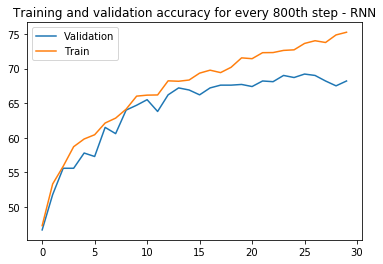

69.2
25
68.2


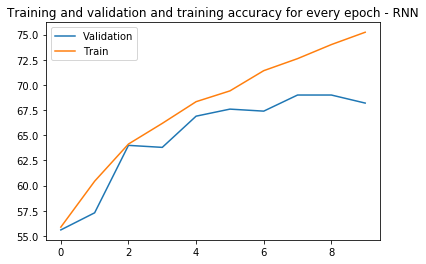

69.0
7
68.2


In [36]:
print(len(val_accuracy_400_gru))
print(len(val_accuracy_epoch_gru))

plt.plot(val_accuracy_400_gru, label = 'Validation')
plt.plot(train_accuracy_400_gru, label = 'Train')
plt.title('Training and validation accuracy for every 800th step - RNN')
plt.legend(loc='upper left')
plt.show()

print(max(val_accuracy_400_gru))
print(val_accuracy_400_gru.index(max(val_accuracy_400_gru)))
print(val_accuracy_400_gru[-1])

plt.plot(val_accuracy_epoch_gru, label = 'Validation')
plt.plot(train_accuracy_epoch_gru, label = 'Train')
plt.title('Training and validation and training accuracy for every epoch - RNN')
plt.legend(loc='upper left')
plt.show()

print(max(val_accuracy_epoch_gru))
print(val_accuracy_epoch_gru.index(max(val_accuracy_epoch_gru)))
print(val_accuracy_epoch_gru[-1])